# Predicting Meteoroid Conditions

## Preliminar

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import minimize,bisect
from scipy.interpolate import interp1d as interpolate
from scipy.integrate import quad as integrate
import statistics as stats
import spiceypy as spy
from copy import deepcopy
from mpl_toolkits.basemap import Basemap as Map,shiftgrid as Grid
from tqdm import tqdm
from scipy.stats import linregress
from glob import glob
from datetime import datetime
from tqdm import tqdm
from scipy import stats
from scipy.stats.distributions import chi2
from os import system
%matplotlib nbagg

#Routines
def ipercs(xs,ps,qpercs):
    """
    Compute percentiles from a numerical normalized distribution ps
    """
    Ps=np.array([ps[:i].sum() for i in range(len(ps))])
    fi=interpolate(Ps,xs)
    return fi(np.array(qpercs)/100.0)

#Routines to convert from local to body systems and viceversa
def loc2rec(vp,distance,Az,h):
    """
    Convert distance, azimuth and elevation to position w.r.t. Earth
    vp (dictionary): Vantage point.  It should have: lon, lat, alt
    distance: km
    Az: deg
    h: deg
    """
    rlocal=spy.latrec(distance,Az*DEG,h*DEG)
    rpos=spy.mxv(vp["l2b"],rlocal)+vp["geopos"]
    return rpos


def rec2loc(vp,rpos):
    """
    Convert position w.r.t. Earth to distance, Azimuth and elevation
    distance: km
    Az: deg
    h: deg
    """
    rrel=rpos-vp["geopos"]
    rlocal=spy.mxv(vp["b2l"],rrel)
    distance,Az,h=spy.reclat(rlocal)
    Az=2*np.pi+Az if Az<0 else Az
    return distance,Az*RAD,h*RAD

def recv2loc(vp,rpos):
    """
    Convert position w.r.t. Earth to distance, Azimuth and elevation
    distance: km
    Az: deg
    h: deg
    """
    rrel=rpos
    rlocal=spy.mxv(vp["b2l"],rrel)
    distance,Az,h=spy.reclat(rlocal)
    Az=2*np.pi+Az if Az<0 else Az
    return distance,Az*RAD,h*RAD

def updateVantagePoint(vp):
    """
    Compute related geometrical properties of a vantage point
    """
    vp["geopos"]=spy.georec(vp["lon"]*DEG,vp["lat"]*DEG,vp["alt"],RE,F)
    normal=spy.surfnm(RE,RE,RP,vp["geopos"])
    uy=spy.ucrss(np.array([0,0,1]),normal)
    ux=spy.ucrss(normal,uy)
    vp["l2b"]=np.array(np.vstack((ux,uy,normal)).transpose().tolist())
    vp["b2l"]=np.linalg.inv(vp["l2b"])
    
def greatCircle(lon1,lat1,lon2,lat2):
    a=np.sin((lat2-lat1)/2)**2+np.cos(lat1)*np.cos(lat2)*np.sin((lon2-lon1)/2)**2
    gd=2*np.arctan2(np.sqrt(a),np.sqrt(1-a))
    return gd

In [4]:
#To take effect it should be executed twice
%matplotlib nbagg

### SPICE specifics

In [5]:
BDIR="./"
spy.furnsh(BDIR+"kernels/de430.bsp")
spy.furnsh(BDIR+"kernels/naif0012.tls")
spy.furnsh(BDIR+"kernels/pck00010.tpc")
spy.furnsh(BDIR+"kernels/earth_070425_370426_predict.bpc")
spy.furnsh(BDIR+"kernels/earth_assoc_itrf93.tf")
#Astronomical constants
n,rs=spy.bodvrd("EARTH","RADII",3)
RE=rs[0];RP=rs[2]
F=(RE-RP)/RE

### Macro and Constants

In [6]:
#Directories
FIGDIR=BDIR+"figures/"

#Macros
norm=np.linalg.norm
DEG=np.pi/180
RAD=1/DEG

#Fitting procedure
lengthTestTrajectory=300 #km
npointsTestTrajectory=50

## Impact data

In [7]:
#Read vantage positions position
havana=pd.read_csv("data/havana-observations-final.csv",decimal=",")
florida=pd.read_csv("data/florida-observations-final.csv",decimal=",")
#pinar=pd.read_csv("data/pinardelrio-observations-correction.csv",decimal=",") # d = 9 m
#pinar=pd.read_csv("data/pinardelrio-observations-correction2.csv",decimal=",") # d = 8,5 m
#pinar=pd.read_csv("data/pinardelrio-observations-correction3.csv",decimal=",") # d = 8 m
pinar=pd.read_csv("data/pinardelrio-observations-correction4.csv",decimal=",") # h = 9 m, d = 8 m

#Build vantage points dictionary
#T in C, P in kPa.  Weather data taken from historical data in : https://www.wunderground.com
vantagePoints=dict(
    impact=dict(
        location="Impact",
        obstraj_nocorr=None,
        lon=0,lat=0,alt=0,
        Azref=0.0,
        T=0,P=0,
        Atmcorr=0,
    ),
    havana=dict(
        location="Havana harbor",
        obstraj_nocorr=havana,
        #lon=-82.344343,lat=23.13799,alt=0/1000.,
        lon=-82.344328,lat=23.137768,alt=0/1000., #Improved 
        Azref=0.0,
        T=30.0,P=101.0,
        Atmcorr=0.3,
    ),
    florida=dict(
        location="GullWing Beach Resort (Florida)",
        obstraj_nocorr=florida,
        lon=-81.903596,lat=26.418871,alt=1/1000.,
        Azref=201.6,
        T=25.0,P=102.3,
        Atmcorr=0.5,
    ),
    pinar=dict(
        location="Pinar del Rio (Cuba)",
        obstraj_nocorr=pinar,
        #lon=-83.692091,lat=22.414536,alt=48/1000.,
        lon=-83.692107,lat=22.414545,alt=48/1000., #Improved
        Azref=0.0,
        T=30.0,P=101.0,
        Atmcorr=0,
    ),
)

#Geometrical properties of the vantage point
for key,vp in vantagePoints.items():updateVantagePoint(vp)
nvp=len(vantagePoints.keys())-1

In [8]:
vantagePoints["pinar"]["obstraj_nocorr"]

,h,herr,Az,Azerr,t
0,71.401080,5,287.610000,0.1,0
1,62.844485,5,305.009927,5.0,0
2,57.064185,5,318.748435,5.0,0


### Correct observations using atmospheric refraction

In [9]:
def Ratm(ha,epsilon):
    """
    Benett formula
    See: https://en.wikipedia.org/wiki/Atmospheric_refraction
    """
    R=1/np.tan((ha+7.31/(ha+4.4))*DEG)
    return R/60.0

In [10]:
for key,vp in vantagePoints.items():
    if key=="impact":continue
    
    print(f"Correcting {key}")
    #Observed trajectory
    obstraj=vp["obstraj_nocorr"]
    vp["obstraj"]=deepcopy(obstraj)
    
    #Correction factor for atmospheric refraction
    #See: https://en.wikipedia.org/wiki/Atmospheric_refraction, Seamundsson formula
    epsilon=vp["P"]/101.0*283./(273+vp["T"])
    #print(f"Weather correction:{epsilon}")
    
    #Atmospheric refraction
    for ind in vp["obstraj_nocorr"].index:
        ha=vp["obstraj_nocorr"].loc[ind,"h"]
        #print(f"Apparent: {ha} deg")
        R=Ratm(ha,epsilon)
        h=ha-vp["Atmcorr"]*R
        vp["obstraj"].loc[ind,"h"]=h
        #print(f"True: {h}")    

Correcting havana
Correcting florida
Correcting pinar


In [11]:
key="florida"
#key="pinar"
#key="havana"
vantagePoints[key]["obstraj_nocorr"],vantagePoints[key]["obstraj"]

(          h      herr         Az     Azerr       t
 0  2.507044  0.253077  10.147311  0.110721  0.4375
 1  2.348871  0.253077  10.202645  0.110721  0.5000
 2  2.000890  0.253077  10.526421  0.110721  0.8125
 3  1.621274  0.253077  10.811132  0.110721  0.9375
 4  1.099303  0.253077  11.199208  0.110721  1.9375
 5  0.838317  0.253077  11.452074  0.110721  2.3125,
           h      herr         Az     Azerr       t
 0  2.373300  0.253077  10.147311  0.110721  0.4375
 1  2.209916  0.253077  10.202645  0.110721  0.5000
 2  1.849125  0.253077  10.526421  0.110721  0.8125
 3  1.453012  0.253077  10.811132  0.110721  0.9375
 4  0.902817  0.253077  11.199208  0.110721  1.9375
 5  0.624681  0.253077  11.452074  0.110721  2.3125)

## Chi-square computation

In [12]:
def chiSquare(param,vps,avoid=[],verbose=False,npoints=npointsTestTrajectory):
    
    #Input parameters
    lonProj=param[0] # deg
    latProj=param[1] # deg
    hrad=param[2] #deg 
    Azrad=param[3] #deg
    
    #Impact position
    vantagePoints["impact"]["lon"]=lonProj
    vantagePoints["impact"]["lat"]=latProj
    vantagePoints["impact"]["alt"]=0.0
    updateVantagePoint(vantagePoints["impact"])
    
    #Reference Azimuth in Florida
    vantagePoints["florida"]["Azref"]=param[4]
    
    #Direction of radiant
    r=loc2rec(vps["impact"],1,Azrad,hrad)-vps["impact"]["geopos"]
    uimp,magn=spy.unorm(r)
    
    #Trajectory with this conditions
    trajectory=np.zeros((npoints,3))
    for i,t in enumerate(np.linspace(0,lengthTestTrajectory,npoints)):
        trajectory[i]=uimp*t+vps["impact"]["geopos"]
        
    #Az,h points of trayectory in vantage point vp
    chi2=0
    chis2=[]
    for key,vp in vps.items():
        if key=="impact" or key in avoid:continue

        #Compute theoretical trajectory
        vp["theotraj"]=np.zeros((npoints,2))
        for i in range(len(trajectory)):
            rpos=trajectory[i]
            d,Az,h=rec2loc(vp,rpos)
            vp["theotraj"][i]=np.array([Az,h])
        
        #Compute chisquare for this vantage point
        otraj=vp["obstraj"].values
        dAzmat=np.array([((otraj[i,2]+vp["Azref"])-vp["theotraj"][:,0])**2/otraj[i,3]**2 for i in range(len(otraj))])
        dhmat=np.array([(otraj[i,0]-vp["theotraj"][:,1])**2/otraj[i,1]**2 for i in range(len(otraj))])
        dposmat=np.sqrt(dAzmat+dhmat)
        vpchi2=dposmat.min(axis=1).sum() #*len(otraj)
        chis2+=[vpchi2]
        chi2+=(vpchi2)
            
    if verbose:return chi2,chis2
    return chi2

### First minimization

<IPython.core.display.Javascript object>


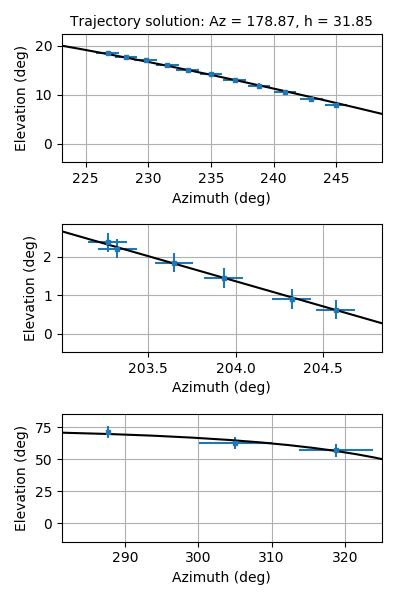

      fun: 6.649418872400429
 hess_inv: array([[ 1.91831920e-05, -4.78633661e-06, -2.91683672e-04,
        -2.04854468e-04, -2.75272745e-04],
       [-4.78633661e-06,  1.22317594e-06,  6.50535427e-05,
         4.39866600e-05,  6.79155764e-05],
       [-2.91683672e-04,  6.50535427e-05,  8.08199096e-03,
         6.93454863e-03,  4.63054416e-03],
       [-2.04854468e-04,  4.39866600e-05,  6.93454863e-03,
         6.54564859e-03,  3.44142568e-03],
       [-2.75272745e-04,  6.79155764e-05,  4.63054416e-03,
         3.44142568e-03,  4.27136415e-03]])
      jac: array([ 0.05083275,  0.11463749,  0.0009253 , -0.00022894,  0.00093859])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 725
      nit: 14
     njev: 102
   status: 2
  success: False
        x: array([-83.80368833,  22.8819587 ,  31.84784283, 178.87387681,
       193.1210162 ])

In [13]:
Npoints=200
lonProj=-83.81626833
latProj=22.8974281
hrad=30.06190132 #deg 
Azrad=172.62676791 #deg
Azref=193 #deg

param=[lonProj,latProj,hrad,Azrad,Azref]
param=np.array([-83.80564464,22.8817404,31.74936293,178.33044947,193.07208362])

solution=minimize(chiSquare,param,args=(vantagePoints,[],False,Npoints),options=dict(maxiter=100))

#Plot solution
plt.ion()
fig,axs=plt.subplots(nvp,figsize=(4,6))
i=-1

for i,ax in enumerate(axs):
    ax.set_xlabel("Azimuth (deg)")
    ax.set_ylabel("Elevation (deg)")

axs[0].set_title(f"Trajectory solution: Az = {solution.x[3]:.2f}, h = {solution.x[2]:.2f}",fontsize=10)

i=-1
for key,vp in vantagePoints.items():
    if key=="impact":continue
    i+=1
    
    #Plot observed points
    axs[i].plot(vp["theotraj"][:,0],vp["theotraj"][:,1],'k-')
    axs[i].errorbar(vp["obstraj"]["Az"]+vp["Azref"],vp["obstraj"]["h"],
                    xerr=vp["obstraj"]["Azerr"],yerr=vp["obstraj"]["herr"],marker='s',ms=3,ls='')
    #axs[i].text(0.9,0.9,vp["location"],ha='right',va='top',transform=axs[i].transAxes)

    #Ranges
    Azmin=(vp["obstraj"]["Az"]+vp["Azref"]).min();Azmax=(vp["obstraj"]["Az"]+vp["Azref"]).max()
    hmin=0;hmax=vp["obstraj"]["h"].max()
    dAz=(Azmax-Azmin)/5.0
    dh=(hmax-hmin)/5.0
    
    axs[i].set_xlim((Azmin-dAz,Azmax+dAz))
    axs[i].set_ylim((hmin-dh,hmax+dh))
    axs[i].grid()
    
fig.tight_layout()
solution

## Deeper minimum search

In [14]:
loncen,latcen,hcen,Acen,Arefcen=solution.x
cparam=[loncen,latcen,hcen,Acen,Arefcen]
chi2_cen=chiSquare(cparam,vantagePoints,npoints=Npoints)
print(f"Cental chi^2 = {chi2_cen}")

Cental chi^2 = 6.649418872400429


In [15]:
Nh=NA=15

In [16]:
dh=2
dA=2
Avec=np.linspace(Acen-dA,Acen+dA,NA,endpoint=True)
hvec=np.linspace(hcen-dh,hcen+dh,Nh,endpoint=True)
Amat,hmat=np.meshgrid(Avec,hvec)

Np=5
dlon=0.05
dlat=0.05

lonvec=np.linspace(loncen-dlon,loncen+dlon,Np,endpoint=True)
latvec=np.linspace(latcen-dlat,latcen+dlat,Np,endpoint=True)

In [17]:
Npoints=200
plt.ioff()
fig,axs=plt.subplots(Np,Np,figsize=(8*Np/2,6*Np/2))
chiglobmin=1e100
m=0
for ip,lon in enumerate(lonvec):
    for jp,lat in enumerate(latvec):
        ax=axs[ip,jp]
        print(f"Computing matrix for (lon,lat) = ({lon},{lat}) [{m+1}/{Np*Np}]")
        CHI2=1e100*np.ones((Nh,NA))
        for n in range(Nh*NA):
            i=np.int(n/NA)
            j=n%NA
            h=hvec[i]
            A=Avec[j]
            cparam=[lon,lat,h,A,Arefcen]
            chi2=chiSquare(cparam,vantagePoints,npoints=Npoints)
            CHI2[i,j]=chi2
            #break
        nmin=CHI2.argmin()
        imin=np.int(nmin/NA)
        jmin=nmin%NA
        chi2min=CHI2.min()
        h=hvec[imin];A=Avec[jmin]
        if chi2min<chiglobmin:
            lat_min=lat
            lon_min=lon
            A_min=A
            h_min=h
            chiglobmin=chi2min
        c=ax.contour(hmat,Amat,CHI2)
        ax.clabel(c)
        ax.plot(h,A,'ko')
        ax.text(h,A,'True Min')
        #ax.plot(hcen,Acen,'bs')
        #ax.text(hcen,Acen,'Local Min')
        ax.set_title(f"{lon:.7f},{lat:.7f}, chi2min = {chi2min:.1f}",fontsize=10)
        #ax.set_title(f"{lon-loncen:.3f},{lat-latcen:.3f}, chi2min = {chi2min:.1f}",fontsize=10)
        print(f"\tMinimum value of chi2: {chi2min}, (h,A) = ({h},{A})")
        m+=1
        #break
    #break
    
print(f"Global minimum: (lon,lat)=({lon_min:.3f},{lat_min:.3f}), (A,h)=({A_min:.1f},{h_min:.1f}), chi2={chiglobmin:.1f}")
fig.tight_layout()
fig.savefig(FIGDIR+"minimization-matriz.png")

Computing matrix for (lon,lat) = (-83.85368833415149,22.831958697608005) [1/25]
	Minimum value of chi2: 20.733328531510928, (h,A) = (32.990699973240496,177.4453053857899)
Computing matrix for (lon,lat) = (-83.85368833415149,22.856958697608007) [2/25]
	Minimum value of chi2: 19.708895742113583, (h,A) = (32.133557116097634,177.1595911000756)
Computing matrix for (lon,lat) = (-83.85368833415149,22.881958697608006) [3/25]
	Minimum value of chi2: 22.009433462001624, (h,A) = (31.562128544669065,177.1595911000756)
Computing matrix for (lon,lat) = (-83.85368833415149,22.906958697608005) [4/25]
	Minimum value of chi2: 22.673051729167675, (h,A) = (30.990699973240492,176.87387681436132)
Computing matrix for (lon,lat) = (-83.85368833415149,22.931958697608007) [5/25]
	Minimum value of chi2: 25.485207905380985, (h,A) = (30.419271401811923,176.87387681436132)
Computing matrix for (lon,lat) = (-83.82868833415148,22.831958697608005) [6/25]
	Minimum value of chi2: 9.419528399823552, (h,A) = (33.56212854

## Error Analysis

### Error in azimuth and altitude

100%|██████████| 225/225 [00:12<00:00, 21.76it/s]


<IPython.core.display.Javascript object>


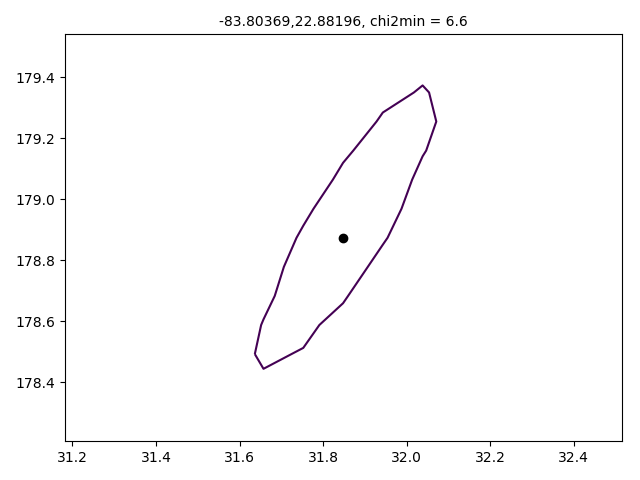

In [18]:
NA=15
Nh=15
dh=2
dA=2
Avec=np.linspace(A_min-dA/3,A_min+dA/3,NA)
hvec=np.linspace(h_min-dh/3,h_min+dh/3,Nh)
Amat,hmat=np.meshgrid(Avec,hvec)

CHI2=1e100*np.ones((Nh,NA))
for n in tqdm(range(Nh*NA)):
    i=np.int(n/NA)
    j=n%NA
    h=hvec[i]
    A=Avec[j]
    cparam=[lon_min,lat_min,h,A,Arefcen]
    chi2=chiSquare(cparam,vantagePoints,npoints=Npoints)
    CHI2[i,j]=chi2

nmin=CHI2.argmin()
imin=np.int(nmin/NA)
jmin=nmin%NA
chi2min=CHI2.min()
h=hvec[imin]
A=Avec[jmin]

plt.ion()
fig=plt.figure()
ax=fig.gca()

#c=ax.contour(hmat,Amat,CHI2)
c=ax.contour(hmat,Amat,CHI2,levels=[chi2min+4])
#ax.clabel(c)
#ax.plot(h,A,'ko')
ax.plot(h_min,A_min,'ko')
#ax.text(h,A,'True Min')
ax.set_title(f"{lon_min:.5f},{lat_min:.5f}, chi2min = {chi2min:.1f}",fontsize=10)

fig.tight_layout()

<IPython.core.display.Javascript object>


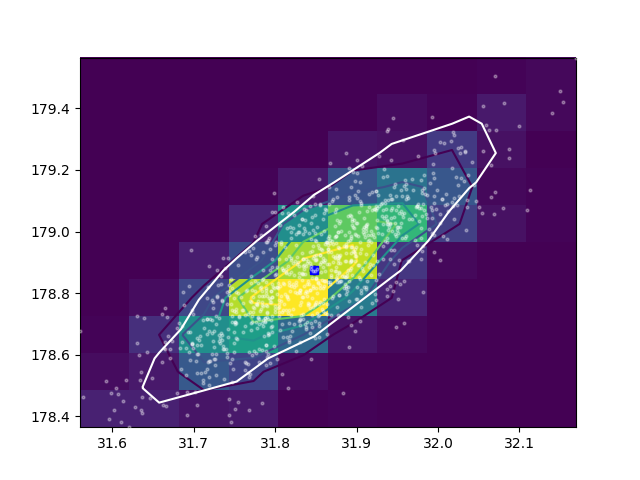

In [19]:
A_error=0.2
h_error=0.1
rhohA=0.8
covMathA=[[h_error**2,rhohA*h_error*A_error],[rhohA*h_error*A_error,A_error**2]]
points=stats.multivariate_normal.rvs([h_min,A_min],covMathA,1000) 

fig=plt.figure()
ax=fig.gca()

h2,hv,Av,m=ax.hist2d(points[:,0],points[:,1])
hmv=(hv[:-1]+hv[1:])/2
Amv=(Av[:-1]+Av[1:])/2
AMV,HMV=np.meshgrid(Amv,hmv)
ax.plot(points[:,0],points[:,1],'wo',ms=2,alpha=0.3,zorder=100)

ax.contour(HMV,AMV,h2)
c=ax.contour(hmat,Amat,CHI2,levels=[chi2min+4],colors=['w'])
ax.plot(h,A,'ko')
ax.plot(hcen,Acen,'bs')

### Error in latitude and longitude

100%|██████████| 225/225 [00:11<00:00, 18.80it/s]

Minimum: Previous = (-83.80368833415149,22.881958697608006), After = (-83.80368833415149,22.881958697608006), chi2 = 6.649418872400429


<IPython.core.display.Javascript object>


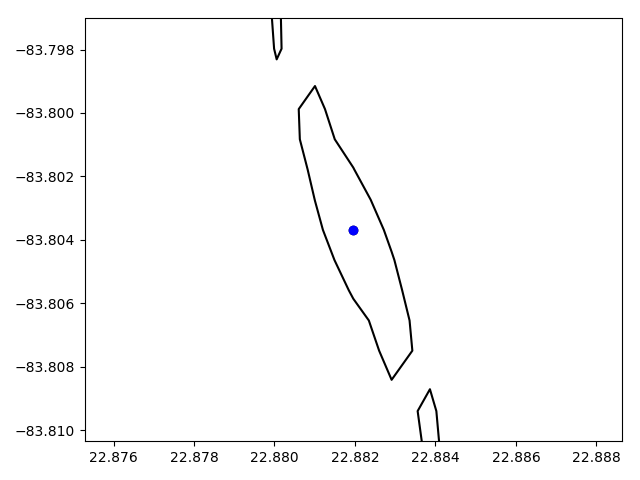

In [20]:
Nlon=15
Nlat=15
dlat=0.02
dlon=0.02
lonvec=np.linspace(lon_min-dlon/3,lon_min+dlon/3,Nlon)
latvec=np.linspace(lat_min-dlat/3,lat_min+dlat/3,Nlat)
lonmat,latmat=np.meshgrid(lonvec,latvec)

CHI2=1e100*np.ones((Nlat,Nlon))
for n in tqdm(range(Nlat*Nlon)):
    i=np.int(n/Nlon)
    j=n%Nlon
    lat=latvec[i]
    lon=lonvec[j]
    cparam=[lon,lat,h_min+(-0)*0.15,A_min+(-0)*0.3,Arefcen]
    chi2=chiSquare(cparam,vantagePoints,npoints=Npoints)
    CHI2[i,j]=chi2

nmin=CHI2.argmin()
imin=np.int(nmin/Nlon)
jmin=nmin%Nlon
chi2min=CHI2.min()
lat=latvec[imin]
lon=lonvec[jmin]
print(f"Minimum: Previous = ({lon_min},{lat_min}), After = ({lon},{lat}), chi2 = {chi2min}")

plt.ion()
fig=plt.figure()
ax=fig.gca()

#c=ax.contour(hmat,Amat,CHI2)
c=ax.contour(latmat,lonmat,CHI2,levels=[chi2min+4],colors=['k'])
#ax.clabel(c)
#ax.plot(lat_min,lon_min,'ko')
ax.plot(lat,lon,'ko')
ax.plot(lat_min,lon_min,'bo')
#ax.text(lat,lon,'True Min')

fig.tight_layout()

#### Error and correlation estimation

<IPython.core.display.Javascript object>


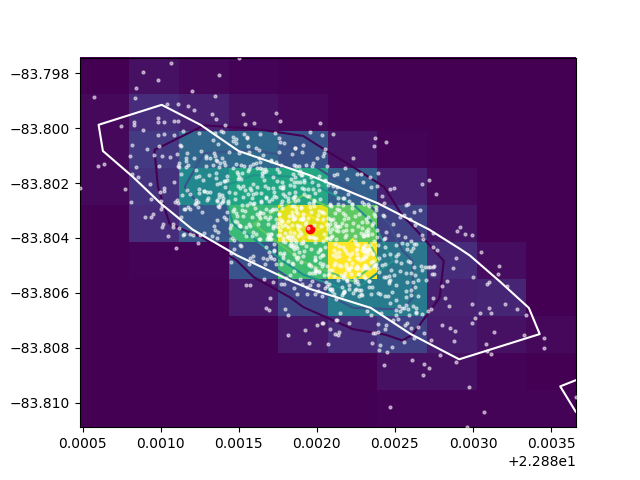

In [21]:
plt.ion()
fig=plt.figure()
ax=fig.gca()

lon_error=0.002
lat_error=0.0005
rholatlon=-0.65
covMatlatlon=[[lat_error**2,rholatlon*lat_error*lon_error],[rholatlon*lat_error*lon_error,lon_error**2]]
points=stats.multivariate_normal.rvs([lat_min,lon_min],covMatlatlon,1000) 

#Contours of points
h2,hv,Av,m=ax.hist2d(points[:,0],points[:,1])
hmv=(hv[:-1]+hv[1:])/2
Amv=(Av[:-1]+Av[1:])/2
AMV,HMV=np.meshgrid(Amv,hmv)
ax.plot(points[:,0],points[:,1],'wo',ms=2,alpha=0.3,zorder=100)
ax.contour(HMV,AMV,h2)

ax.plot(points[:,0],points[:,1],'wo',ms=2,alpha=0.3,zorder=100)
c=ax.contour(latmat,lonmat,CHI2,levels=[chi2min+4],colors=['w'])
ax.plot(lat_min,lon_min,'ro')

### Plot with errors

In [22]:
param=np.array([lon_min,lat_min,h_min,A_min,Arefcen])
chi2_cen=chiSquare(param,vantagePoints,npoints=Npoints,verbose=True)
print(f"Minimum chi^2 = {chi2_cen}")

Minimum chi^2 = (6.649418872400429, [4.913328329117609, 0.8048403746046316, 0.9312501686781888])


In [23]:
covMat=[[h_error**2,rhohA*h_error*A_error,0,0],[rhohA*h_error*A_error,A_error**2,0,0],
        [0,0,lat_error**2,rholatlon*lat_error*lon_error],[0,0,rholatlon*lat_error*lon_error,lon_error**2],
       ]

In [24]:
N=500
params=[]
for n in tqdm(range(N)):
    h,A,lat,lon=stats.multivariate_normal.rvs([h_min,A_min,lat_min,lon_min],
                                              covMat) 
    params+=[[lon,lat,h,A,Arefcen]]

100%|██████████| 500/500 [00:00<00:00, 2203.59it/s]


<IPython.core.display.Javascript object>


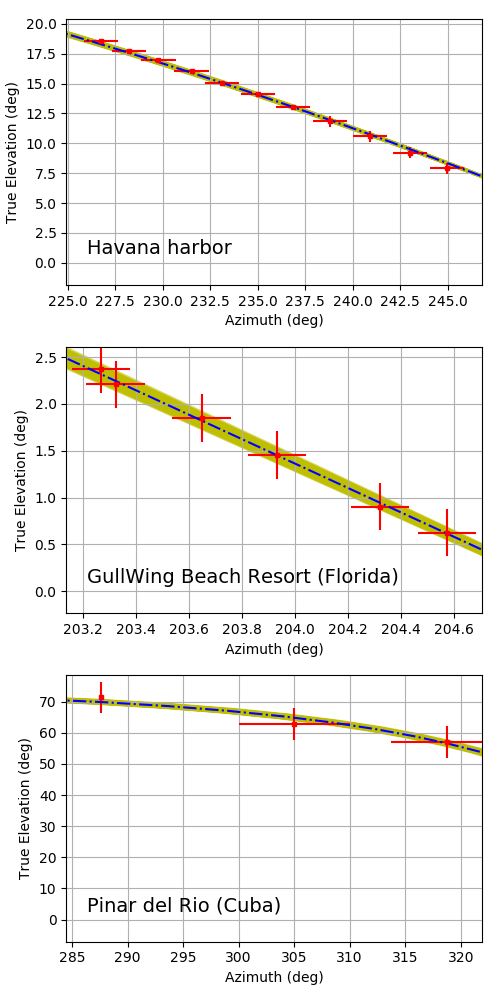

100%|██████████| 500/500 [00:31<00:00, 15.91it/s]


In [25]:
npoints=200

###########################################################################
#DATA
###########################################################################
plt.ion()
fig,axs=plt.subplots(nvp,figsize=(5,10))

i=-1
for key,vp in vantagePoints.items():
    if key=="impact":continue
    i+=1
    
    #Plot observed points
    axs[i].errorbar(vp["obstraj"]["Az"]+vp["Azref"],vp["obstraj"]["h"],
                    xerr=vp["obstraj"]["Azerr"],yerr=vp["obstraj"]["herr"],marker='s',ms=3,ls='',color='r')
    axs[i].text(0.05,0.1,vp["location"],ha='left',va='bottom',transform=axs[i].transAxes,fontsize=14)

    #Ranges
    Azmin=(vp["obstraj"]["Az"]+vp["Azref"]).min();Azmax=(vp["obstraj"]["Az"]+vp["Azref"]).max()
    hmin=0;hmax=vp["obstraj"]["h"].max()
    dAz=(Azmax-Azmin)/10.0
    dh=(hmax-hmin)/10.0
    
    axs[i].set_xlim((Azmin-dAz,Azmax+dAz))
    axs[i].set_ylim((hmin-dh,hmax+dh))
    axs[i].grid()

###########################################################################
#CENTRAL
###########################################################################
param=[lon_min,lat_min,h_min,A_min,Arefcen]

#Direction of radiant
r=loc2rec(vantagePoints["impact"],1,param[3],param[2])-vantagePoints["impact"]["geopos"]
uimp,magn=spy.unorm(r)
trajectory=np.zeros((npoints,3))
for i,t in enumerate(np.linspace(0,lengthTestTrajectory,npoints)):
    trajectory[i]=uimp*t+vantagePoints["impact"]["geopos"]

for key,vp in vantagePoints.items():
    if key=="impact":continue
    vp["theotraj"]=np.zeros((npoints,2))
    for i in range(len(trajectory)):
        rpos=trajectory[i]
        d,Az,h=rec2loc(vp,rpos)
        vp["theotraj"][i]=np.array([Az,h])

i=-1
for key,vp in vantagePoints.items():
    if key=="impact":continue
    i+=1

    #Plot observed points
    axs[i].plot(vp["theotraj"][:,0],vp["theotraj"][:,1],'b-.')
    
###########################################################################
#THEORETICAL
###########################################################################
for n in tqdm(range(N)):
    param=params[n]

    #Direction of radiant
    r=loc2rec(vantagePoints["impact"],1,param[3],param[2])-vantagePoints["impact"]["geopos"]
    uimp,magn=spy.unorm(r)
    trajectory=np.zeros((npoints,3))
    for i,t in enumerate(np.linspace(0,lengthTestTrajectory,npoints)):
        trajectory[i]=uimp*t+vantagePoints["impact"]["geopos"]

    for key,vp in vantagePoints.items():
        if key=="impact":continue
        vp["theotraj"]=np.zeros((npoints,2))
        for i in range(len(trajectory)):
            rpos=trajectory[i]
            d,Az,h=rec2loc(vp,rpos)
            vp["theotraj"][i]=np.array([Az,h])

    i=-1
    for key,vp in vantagePoints.items():
        if key=="impact":continue
        i+=1

        #Plot observed points
        axs[i].plot(vp["theotraj"][:,0],vp["theotraj"][:,1],'y-',alpha=0.2,zorder=-10)
    
i=-1
for i,ax in enumerate(axs):
    ax.set_xlabel("Azimuth (deg)")
    ax.set_ylabel("True Elevation (deg)")

fig.savefig(FIGDIR+"trajectory-fit.png")
fig.tight_layout()

## Compute speeds using errors

<IPython.core.display.Javascript object>


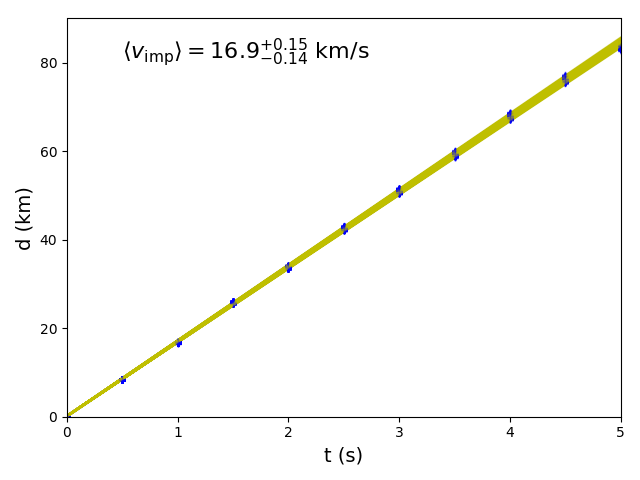

100%|██████████| 500/500 [00:13<00:00, 37.69it/s]


In [26]:
fig=plt.figure()
ax=fig.gca()

#Information on vantage point
vp=vantagePoints["havana"]

vimps=[]
#for n in tqdm(range(N)):
for n in tqdm(range(N)):
    param=params[n]

    #Compute trajectory for this parameters
    r=loc2rec(vantagePoints["impact"],1,param[3],param[2])-vantagePoints["impact"]["geopos"]
    uimp,magn=spy.unorm(r)
    trajectory=np.zeros((npoints,3))
    for i,t in enumerate(np.linspace(0,lengthTestTrajectory,npoints)):
        trajectory[i]=uimp*t+vantagePoints["impact"]["geopos"]

    #Compute theoretical trajectory from the vantage point point of view
    vp["theotraj"]=np.zeros((npoints,2))
    for i in range(len(trajectory)):
        rpos=trajectory[i]
        d,Az,h=rec2loc(vp,rpos)
        vp["theotraj"][i]=np.array([Az,h])
    
    #Build fulltrajectory
    fulltrajectory=np.concatenate((trajectory,vp["theotraj"]),axis=1)

    #Interpolate positions
    xfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,0])
    yfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,1])
    zfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,2])

    #Calculate distance cover between observed points
    spoints=np.zeros((len(vp["obstraj"]),5))
    for i,point in enumerate(vp["obstraj"].values):
        Az=point[2]+vp["Azref"]
        t=point[4]
        intpoint=[float(xfunc(Az)),float(yfunc(Az)),float(zfunc(Az))]
        if i==0:
            distance=0
        else:
            distance=norm(intpoint-spoints[0,:3])
        spoints[i]=np.array(intpoint+[distance,t])

    #Ranges
    tmin=spoints[:,4].min();tmax=spoints[:,4].max()

    #Perform linear regression of times and distances
    regression=linregress(spoints[:,4],spoints[:,3])
    d0=regression.intercept;vimp=regression.slope
    vimps+=[vimp]
    
    ax.plot(spoints[:,4],spoints[:,3],'b+',ms=5,alpha=0.3)
    ts=np.linspace(tmin,tmax,100)
    ax.plot(ts,d0+vimp*ts,'y-',alpha=0.3)
    
    #if n>100:break

vimps=np.array(vimps)
vimp_low,vimp_med,vimp_up=np.percentile(vimps,[5,50,95])
vimp=vimp_med
dvimpu=vimp_up-vimp
dvimpl=vimp_low-vimp
dvimp=(dvimpu-dvimpl)/2

ax.set_xlabel("t (s)",fontsize=14)
ax.set_ylabel("d (km)",fontsize=14)
ax.text(0.1,0.9,r"$\langle v_{\rm imp}\rangle=%.1f^{%+.2f}_{%+.2f}$ km/s"%(vimp,dvimpu,dvimpl),
        transform=ax.transAxes,fontsize=16)
ymin,ymax=ax.get_ylim()
ax.set_xlim((0,tmax))
ax.set_ylim((0,ymax))
fig.tight_layout()
fig.savefig(FIGDIR+"impact-speed.png")

## Orbital analysis

### Generate initial conditions for gravitational ray tracing

In [27]:
outdir="data/cuba-impact"
system(f"rm -r {outdir};mkdir -p {outdir}/grt-Cuba_impact-results")
fi=open(f"{outdir}/cuba-impact.sh","w")

for n in range(N):
    fl=open(f"{outdir}/locations.dat.cuba_error_{n:04d}","w")
    fd=open(f"{outdir}/directions.dat.cuba_error_{n:04d}","w")
    fv=open(f"{outdir}/velocities.dat.cuba_error_{n:04d}","w")
    fi.write(f"python makeagravray.py '02/01/2019 18:17:00 UTC' deg {outdir}/locations.dat.cuba_error_{n:04d} deg {outdir}/directions.dat.cuba_error_{n:04d} 0 {outdir}/velocities.dat.cuba_error_{n:04d} 'Cuba_error_{n:04d}' 4000\n")
    param=params[n]
    v=vimps[n]
    h=param[2]
    Az=param[3]
    lon=param[0]
    lat=param[1]
    fv.write(f"{v}\t-1\n")
    fd.write(f"-1\t-1\t{Az}\t{h}\n")
    fl.write(f"-1\t-1\t{lon}\t{lat}\n")
    fv.close()
    fd.close()
    fl.close()
fi.close()
out=system(f"tar cf cuba-impact-initials.tar {outdir}")

Now follow this steps:

1. Copy the initials tarfile to the GravRay server.

2. In the Gravray server:

   a. cd GravRay
   
   b. ``rm -r data/cuba-impact/;rm -rf data/grt-Cuba_error_*;tar xf cuba-impact-initials.tar``
   
   c. ``bash data/cuba-impact/cuba-impact.sh``
   
   d. ``for phys in data/grt-Cuba_error_*/*.phys;do name=$(echo $phys |awk -F"-" '{print $2}');filename=$(basename $phys);cp $phys data/cuba-impact/grt-Cuba_impact-results/$name-$filename;done``
   
   e. 
   

# *Now you should run the GRT analysis*

### Analysis of GRT results

In [31]:
direrror="data/cuba-impact/grt-Cuba_impact-results/"

for i,physfile in enumerate(glob(f"{direrror}/*.phys")):
    data=np.loadtxt(physfile)
    if i==0:
        alldata=[data]
    else:
        alldata=np.concatenate((alldata,[data]),axis=0)

In [32]:
#Compute semimajor axis, period and Tisserand parameter
aes=alldata[:,9]/(1-alldata[:,10])
Ps=aes**1.5
Tps=1/aes+2*np.cos(alldata[:,11]*DEG)*np.sqrt(aes*(1-alldata[:,10]**2))
alldata=np.column_stack((alldata,aes,Ps,Tps))
        
#Perform analysis
percentiles=np.percentile(alldata,[5,50,90],axis=0)

In [33]:
props=[
    dict(
        name="a",
        symbol="a",
        units="AU",
        ind=16,
    ),
    dict(
        name="q",
        symbol="q",
        units="AU",
        ind=9,
    ),
    dict(
        name="e",
        symbol="e",
        units="AU",
        ind=10,
    ),
    dict(
        name="i",
        symbol="i",
        units="AU",
        ind=11,
    ),
    dict(
        name="W",
        symbol="\Omega",
        units="AU",
        ind=12,
    ),
    dict(
        name="o",
        symbol="\omega",
        units="AU",
        ind=13,
    ),
    dict(
        name="P",
        symbol="P",
        units="yr",
        ind=17,
    ),
    dict(
        name="Tp",
        symbol="T_p",
        units="adim.",
        ind=18,
    ),
]
pmeds=dict()
for prop in props:
    name=prop["name"]
    pmin,pmed,pmax=percentiles[:,prop["ind"]]
    pmeds[name]=pmed
    dpp=pmax-pmed;dpm=pmed-pmin
    print(f"{name} = {pmed:.2f}, d{name} = {(dpp+dpm)/2:.2g},")

a = 1.22, da = 0.0039,
q = 0.74, dq = 0.0048,
e = 0.39, de = 0.0058,
i = 11.47, di = 0.034,
W = 132.28, dW = 0.0018,
o = 276.98, do = 0.47,
P = 1.34, dP = 0.0065,
Tp = 2.81, dTp = 0.005,


In [34]:
#Look for the closest trajectory
minsum=1e100
minelementos=None
for data in alldata:
    #print(data)
    suma=0
    elementos=dict()
    for prop in props:
        name=prop["name"]
        if name=="a":factor=1.0
        else:factor=1.0
        col=prop["ind"]
        val=data[col]
        suma+=factor*(val-pmeds[name])**2
        elementos[name]=val
        #print(f"{name} = {data[col]}, ref = {pmeds[name]}")
    suma=np.sqrt(suma)
    if suma<minsum:
        minsum=suma
        minelementos=elementos
        
print("Average elements:\n",pmeds)
print("Elements of the closest test particle:\n",minelementos)


Average elements:
 {'a': 1.2164735432178357, 'q': 0.7404722585489574, 'e': 0.3913073958445621, 'i': 11.469559067252282, 'W': 132.28053611067685, 'o': 276.97526153796804, 'P': 1.3416956199998569, 'Tp': 2.811392691125861}
Elements of the closest test particle:
 {'a': 1.2166297125673706, 'q': 0.7403811138831954, 'e': 0.39144909397221644, 'i': 11.470630883736069, 'W': 132.28064202741314, 'o': 276.97455999569996, 'P': 1.34195399608857, 'Tp': 2.8113755160305733}


## Mass and size of the rock

In [35]:
KTON=4.184e12 #J

#Estimated airburst energy
E=1.4*KTON #according to NASA Fireball database

#Luminous efficiency
eta=0.1

In [36]:
#Kinetic energy
K=E/eta

In [37]:
#Mass
M=2*K/(vimp*1e3)**2
print(f"Mass of the impactor: {M/1000:.0f} tons")

#Estimated density
rho=2600 #kg/m^2

#Diameter
D=2*(3*M/(4*np.pi*rho))**(1/3)
print(f"Diameter of the impactor: {D:.0f} m")

Mass of the impactor: 411 tons
Diameter of the impactor: 7 m


## Google Earth Files

### Full Trajectory

In [38]:
#Find trajectory from first sight in Havana
vp=vantagePoints["havana"]
Azmin=(vp["obstraj"]["Az"].values+vp["Azref"]).min()

#Traverse the theoretical trajectory
dAzmin_min=1e100
imin=0
for i in range(len(trajectory)):
    rpos=trajectory[i]
    d,Az,h=rec2loc(vp,rpos)
    dAzmin=np.abs(Az-(Azmin))
    dAzmax=np.abs(Az-(Azmax))
    if dAzmin<=dAzmin_min:
        imin=i
        dAzmin_min=dAzmin
trajectory_sel=trajectory[0:imin]

#Compute geographical positions
traj=trajectory_sel 
trajectory_geo=[]
for i,point in enumerate(traj):
    lon,lat,alt=spy.recgeo(point,RE,F)
    if alt>80:break
    trajectory_geo+=[[lon*RAD,lat*RAD,alt]]
trajectory_geo=np.array(trajectory_geo)

In [39]:
trajstr=""
footprint=""
polygon=f"				{trajectory_geo[0,0]},{trajectory_geo[0,1]},0\n"
for point in trajectory_geo:
    trajstr+=f"				{point[0]},{point[1]},{point[2]*1000}\n"
    footprint+=f"				{point[0]},{point[1]},0\n"
    polygon+=f"				{point[0]},{point[1]},{point[2]*1000}\n"
polygon+=f"				{trajectory_geo[-1,0]},{trajectory_geo[-1,1]},0\n"
polygon+=f"				{trajectory_geo[0,0]},{trajectory_geo[0,1]},0\n"

f=open(BDIR+"data/cuba-trajectory-Zuluaga_et_al_2019.kml","w")
f.write(f"""<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns:kml="http://www.opengis.net/kml/2.2" xmlns:atom="http://www.w3.org/2005/Atom">
<Document>
	<name>Cuba Meteor Trajectory, Zuluaga et al. (2019)</name>
	<Style id="trajectory">
		<IconStyle>
		</IconStyle>
		<BalloonStyle>
		</BalloonStyle>
		<LineStyle>
			<color>ff1bffd9</color>
			<width>2.5</width>
		</LineStyle>
	</Style>
	<Style id="footprint">
		<IconStyle>
		</IconStyle>
		<BalloonStyle>
		</BalloonStyle>
		<LineStyle>
			<color>FF3611fc</color>
			<width>2.5</width>
		</LineStyle>
	</Style>
	<Style id="polygon">
		<LineStyle>
			<color>7F3611fc</color>
			<width>0</width>
		</LineStyle>
		<PolyStyle>
            <color>7F3611fc</color>
            <fill>1</fill>
		</PolyStyle>
	</Style>
	<Placemark>
		<name>Trajectory</name>
		<styleUrl>trajectory</styleUrl>
		<LineString>
			<tessellate>1</tessellate>
			<altitudeMode>relativeToGround</altitudeMode>
			<coordinates>
                {trajstr}
            </coordinates>
		</LineString>
	</Placemark>
	<Placemark>
		<name>Footprint</name>
		<styleUrl>footprint</styleUrl>
		<LineString>
			<tessellate>1</tessellate>
            <altitudeMode>clampToGround</altitudeMode>
			<coordinates>
                {footprint}
            </coordinates>
		</LineString>
	</Placemark>
	<Placemark>
		<name>Polygon</name>
		<styleUrl>polygon</styleUrl>
		<Polygon>
			<altitudeMode>relativeToGround</altitudeMode>
			<outerBoundaryIs>
				<LinearRing>
					<coordinates>
                        {polygon}
                    </coordinates>
				</LinearRing>
			</outerBoundaryIs>
		</Polygon>
	</Placemark>
</Document>
</kml>
""")
f.close()

### Apparent trajectories from vantage points

In [40]:
vantagePoints["havana"]["kmlcolor"]="F04614"
vantagePoints["florida"]["kmlcolor"]="3CBE14"
vantagePoints["pinar"]["kmlcolor"]="5078F0"

for key,vp in vantagePoints.items():
    if key=="impact":continue
    print(f"Preparing all trajectory products for '{key}' vantage point...")
    kmlcolor=vp["kmlcolor"]
    location=vp["location"]
    vplon=vp["lon"]
    vplat=vp["lat"]
    vpalt=vp["alt"]*1000

    #Range of interpolation
    Azmin=(vp["obstraj"]["Az"].values+vp["Azref"]).min()
    Azmax=(vp["obstraj"]["Az"].values+vp["Azref"]).max()

    #Traverse the theoretical trajectory
    dAzmin_min=1e100
    dAzmax_min=1e100
    dgreat_min=0
    dgreat_max=0
    dgreats=[]
    imin=0;imax=0
    for i in range(len(trajectory)):
        rpos=trajectory[i]
        d,Az,h=rec2loc(vp,rpos)
        if i==0:
            Azini=Az
            hini=h
            dgreat=0
        else:
            dgreat=greatCircle(Az*DEG,h*DEG,Azini*DEG,hini*DEG)*RAD
        dgreats+=[dgreat]
        dAzmin=np.abs(Az-(Azmin))
        dAzmax=np.abs(Az-(Azmax))
        if dAzmin<=dAzmin_min:
            imin=i
            dAzmin_min=dAzmin
            dgreat_min=dgreat
        if dAzmax<=dAzmax_min:
            imax=i
            dAzmax_min=dAzmax
            dgreat_max=dgreat
    trajectory_sel=trajectory[imax:imin]
    
    #Store only the great circle distance for Pinar del Rio
    if key=="pinar":
        print(f"Initial point of Pinar del Rio: {imin}")
        imin_sel=imin
        dgreats_sel=dgreats
    
    #Geographical trajectory
    traj=trajectory_sel #This is the trajectory only for the Vantage point
    trajectory_geo=[]
    for i,point in enumerate(traj):
        lon,lat,alt=spy.recgeo(point,RE,F)
        if alt>80:break
        trajectory_geo+=[[lon*RAD,lat*RAD,alt]]
    trajectory_geo=np.array(trajectory_geo)
    
    #Build fulltrajectory
    vp["fulltraj"]=fulltrajectory=np.concatenate((trajectory,vp["theotraj"]),axis=1)

    #Interpolate positions
    xfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,0])
    yfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,1])
    zfunc=interpolate(fulltrajectory[:,3],fulltrajectory[:,2])

    #Calculate distance cover between observed points
    vp["spoints"]=spoints=np.zeros((len(vp["obstraj"]),8))
    for i,point in enumerate(vp["obstraj"].values):
        Az=point[2]+vp["Azref"]
        t=point[4]
        intpoint=[float(xfunc(Az)),float(yfunc(Az)),float(zfunc(Az))]
        lon,lat,alt=spy.recgeo(intpoint,RE,F)
        if i==0:
            distance=0
        else:
            distance=norm(intpoint-spoints[0,:3])
        spoints[i]=np.array(intpoint+[distance,t,lon*RAD,lat*RAD,alt])
        
    #Generate kml trajectory
    trajstr=""
    polygon=""
    polygon+=f"				{vplon},{vplat},{vpalt}\n"
    polygon+=f"				{trajectory_geo[0,0]},{trajectory_geo[0,1]},{trajectory_geo[0,2]*1000}\n"
    polygon+=f"				{trajectory_geo[-1,0]},{trajectory_geo[-1,1]},{trajectory_geo[-1,2]*1000}\n"
    polygon+=f"				{vplon},{vplat},{vpalt}\n"
    for point in trajectory_geo:
        trajstr+=f"				{point[0]},{point[1]},{point[2]*1000}\n"

    f=open(BDIR+f"data/cuba-{key}-Zuluaga_et_al_2019.kml","w")
    f.write(f"""<?xml version="1.0" encoding="UTF-8"?>
<kml xmlns="http://www.opengis.net/kml/2.2" xmlns:gx="http://www.google.com/kml/ext/2.2" xmlns:kml="http://www.opengis.net/kml/2.2" xmlns:atom="http://www.w3.org/2005/Atom">
<Document>
	<name>{location} - Cuba Meteor Trajectory, Zuluaga et al. (2019)</name>
	<Style id="polygon">
		<LineStyle>
			<color>7F3611fc</color>
			<width>0</width>
		</LineStyle>
		<PolyStyle>
            <color>7f{kmlcolor}</color>
            <fill>1</fill>
		</PolyStyle>
	</Style>
	<Placemark>
		<name>Polygon</name>
		<styleUrl>polygon</styleUrl>
		<Polygon>
			<altitudeMode>relativeToGround</altitudeMode>
			<outerBoundaryIs>
				<LinearRing>
					<coordinates>
                        {polygon}
                    </coordinates>
				</LinearRing>
			</outerBoundaryIs>
		</Polygon>
	</Placemark>
</Document>
</kml>
""")
    f.close()

Preparing all trajectory products for 'havana' vantage point...
Preparing all trajectory products for 'florida' vantage point...
Preparing all trajectory products for 'pinar' vantage point...
Initial point of Pinar del Rio: 38


In [41]:
iexpl=35
dexpl=dgreats_sel[iexpl]-dgreats_sel[imin_sel]
geoexpl=spy.recgeo(trajectory[iexpl],RE,F)
print(f"Angle from top of the pole to explosion: {dexpl} deg")
print(f"Height of the explosion: {geoexpl[2]} km")

Angle from top of the pole to explosion: -7.739936990526303 deg
Height of the explosion: 27.966294012404266 km


In [42]:
#vp=vantagePoints["havana"]
vp=vantagePoints["pinar"]
#vp=vantagePoints["florida"]
pd.DataFrame(vp["spoints"],columns=["x","y","z","d","t","lon","lat","alt"])

,x,y,z,d,t,lon,lat,alt
0,640.795487,-5891.246057,2431.545675,0.000000,0.0,-83.792297,22.444090,30.410017
1,640.277037,-5887.380370,2434.306875,4.778760,0.0,-83.793240,22.480420,27.861739
2,639.671228,-5882.863320,2437.533335,10.362737,0.0,-83.794342,22.522907,24.887329


## LaTeX Tables and Macros

### Observations

In [43]:
f=open(f"{FIGDIR}/tab-vantage-points.tex","w")
f.write("""%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
%EVENTS
\\begin{table}
\\centering
\\begin{tabular}{llll}
\\hline\\hline
Point & Az. (deg) & h (deg) & t (s)\\\\
""")
for key,vp in vantagePoints.items():
    if key=="impact":continue
    f.write("\\hline\\multicolumn{4}{c}{%s}\\\\\\hline\n"%vp['location'])

    for i,point in enumerate(vp["obstraj"].values):
        if key=="pinar":t="-"
        else:t=f"{point[4]:.2f}"
        if key=="florida":Az=r"$A_{\rm ref}$"+f"+{point[2]:.1f}"
        else:Az=f"{point[2]:.2f}"            
        #print(f"{i+1} & %.1f $\pm$ {point[3]:.1g} & {point[0]:.1f} $\pm$ {point[1]:.1g} & {t} \\\\"%(point[2]+vp["Azref"]))
        f.write(f"{i+1} & {Az} $\pm$ {point[3]:.1g} & {point[0]:.1f} $\pm$ {point[1]:.1g} & {t} \\\\\n"%(point[2]+vp["Azref"]))

f.write("""\hline\hline
\\multicolumn{4}{l}{\\footnotesize*$A_{\\rm ref}$ is obtained in the fitting procedure.}\\\\
\\end{tabular}
\\caption{Observed trajectory of the meteor in the sky as estimated in this work for three different vantage points.\label{tab:measurements}}
\\end{table}
%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
""")
f.close()

### Locations

In [71]:
f=open(f"{FIGDIR}/tab-locations.tex","w")
f.write(f"""%%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
%%EVENTS
\\begin{{table*}}
\\centering
\\begin{{tabular}}{{llllll}}
\\hline\\hline
Location & long. (deg) & lat. (deg) & alt. (m) & Public & Alternative \\\\\\hline
Havana Harbor, Cuba & {vantagePoints['havana']['lon']:.5f} & {vantagePoints['havana']['lat']:.5f} & {vantagePoints['havana']['alt']:.0f} & \\url{{http://bit.ly/2GwIQqB}} & \\url{{http://bit.ly/2UJ18c2}} \\\\
%%
Gull Wing Beach Resrot, FL USA & {vantagePoints['florida']['lon']:.5f} & {vantagePoints['florida']['lat']:.5f} & {vantagePoints['florida']['alt']:.0f} & \\url{{http://bit.ly/2tgUU7q}} & \\url{{http://bit.ly/2TGGp8A}} \\\\
%%
Alameda Pinar del Rio, Cuba & {vantagePoints['pinar']['lon']:.5f} & {vantagePoints['pinar']['lat']:.5f} & {vantagePoints['pinar']['alt']:.0f} & - & \\url{{http://bit.ly/2thGkMZ}} \\\\\\hline
\\end{{tabular}}
\\caption{{Location of the vantages points where the footage used in this work were taken.  Public links are the original social network material.  Alternative are permanent link to the footage.}}
\\label{{tab:vantagepoints}}
\\end{{table*}}
%%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
""")
f.close()

### Orbital solution

In [44]:
elementos=dict()
for prop in props:
    name=prop["name"]
    pmin,pmed,pmax=percentiles[:,prop["ind"]]
    dpp=pmax-pmed;dpm=pmin-pmed
    pmed=minelementos[name]
    elementos[name]=[pmed,dpp,dpm]

In [45]:
f=open(f"{FIGDIR}/tab-orbital-solution.tex","w")
f.write(f"""
%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
%EVENTS
\\begin{{table}}
\\centering
\\begin{{tabular}}{{ccc}}
\\hline\\hline
Parameter & Best fit value\\\\
\\hline
\\multicolumn{{2}}{{c}}{{Atmospheric trajectory}}\\\\
\\hline
Lon. impact (deg) & \\hl{{{lon_min:+.4f} $\\pm$ {lon_error:.3f}}} \\\\
Lat. impact (deg) & \\hl{{{lat_min:+.4f} $\\pm$ {lat_error:.3f}}} \\\\
$A_{{\\rm rad}}$ (deg) & \\hl{{{A_min:.1f} $\\pm$ {A_error:.1f}}} \\\\
$h_{{\\rm rad}}$ (deg) & \\hl{{{h_min:.1f} $\\pm$ {h_error:.1f}}} \\\\
$A_{{\\rm ref}}$ (deg) & \\hl{{{Arefcen:.1f}}} \\\\
$\\langle v_{{\\rm imp}}\\rangle$ (km/s) & ${vimp:.1f}^{{{dvimpu:+.2f}}}_{{{dvimpl:+.2f}}}$ \\\\
\\hline
\\multicolumn{{2}}{{c}}{{Orbit}}\\\\
\\hline
""")
f.write(f"$a$ (AU) & ${{{elementos['a'][0]:.3f}}}^{{{elementos['a'][1]:+.3f}}}_{{{elementos['a'][2]:+.3f}}}$\\\\\n")
f.write(f"$q$ (AU) & ${{{elementos['q'][0]:.3f}}}^{{{elementos['q'][1]:+.3f}}}_{{{elementos['q'][2]:+.3f}}}$\\\\\n")
f.write(f"$e$ & ${{{elementos['e'][0]:.3f}}}^{{{elementos['e'][1]:+.3f}}}_{{{elementos['e'][2]:+.3f}}}$\\\\\n")
f.write(f"$i$ (deg) & ${{{elementos['i'][0]:.3f}}}^{{{elementos['i'][1]:+.3f}}}_{{{elementos['i'][2]:+.3f}}}$\\\\\n")
f.write(f"$\Omega$ (deg) & ${{{elementos['W'][0]:.3f}}}^{{{elementos['W'][1]:+.3f}}}_{{{elementos['W'][2]:+.3f}}}$\\\\\n")
f.write(f"$\omega$ (deg) & ${{{elementos['o'][0]:.3f}}}^{{{elementos['o'][1]:+.3f}}}_{{{elementos['o'][2]:+.3f}}}$\\\\\n")
f.write(f"$P$ (yr) & ${{{elementos['P'][0]:.3f}}}^{{{elementos['P'][1]:+.3f}}}_{{{elementos['P'][2]:+.3f}}}$\\\\\n")
f.write(f"$T_p$ & ${{{elementos['Tp'][0]:.3f}}}^{{{elementos['Tp'][1]:+.3f}}}_{{{elementos['Tp'][2]:+.3f}}}$\\\\\n")
f.write(f"""
\\hline
\\end{{tabular}}
\\caption{{Best-fit values of the atmospheric trajectory and the asymptotic orbit of the meteoroid for the Cuba impact as estimated in this work.}}
\\label{{tab:fit}}
\\end{{table}}
%TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT
""")

f.close()

In [46]:
conditions=[
    [h_min,h_error],
    [A_min,A_error],
    [vimp,dvimp],
    #Orbitla Elements
    [elementos["a"][0],(elementos["a"][1]-elementos["a"][2])/2],
    [elementos["q"][0],(elementos["q"][1]-elementos["q"][2])/2],
    [elementos["e"][0],(elementos["e"][1]-elementos["e"][2])/2],
    [elementos["i"][0],(elementos["i"][1]-elementos["i"][2])/2],
    [elementos["W"][0],(elementos["W"][1]-elementos["W"][2])/2],
    [elementos["o"][0],(elementos["o"][1]-elementos["o"][2])/2],
]
np.savetxt("data/impact-conditions.data",conditions)

### Macros

In [76]:
f=open(f"{FIGDIR}/macros.tex","w")
f.write(f"""
%%ORBITAL ELEMENTS
\\newcommand{{\\aimp}}{{{elementos['a'][0]:.3f}}}
\\newcommand{{\\eimp}}{{{elementos['e'][0]:.3f}}}
\\newcommand{{\\eapprox}}{{{elementos['e'][0]:.1f}}}
\\newcommand{{\\qimp}}{{{elementos['q'][0]:.2f}}}
\\newcommand{{\\iimp}}{{{elementos['i'][0]:.2f}}}
\\newcommand{{\\iapprox}}{{{elementos['i'][0]:.0f}}}
\\newcommand{{\\Wimp}}{{{elementos['W'][0]:.2f}}}
\\newcommand{{\\wimp}}{{{elementos['o'][0]:.2f}}}
\\newcommand{{\\Pimp}}{{{elementos['P'][0]:.2f}}}
\\newcommand{{\\Tpimp}}{{{elementos['Tp'][0]:.2f}}}

%%IMPACT CONDITIONS
\\newcommand{{\\lonimp}}{{{lon_min:+.4f}}}
\\newcommand{{\\latimp}}{{{lat_min:+.4f}}}
\\newcommand{{\\Arad}}{{{A_min:.1f}}}
\\newcommand{{\\hrad}}{{{h_min:.1f}}} %%deg
\\newcommand{{\\vimpval}}{{{vimp:.1f}}} %%deg
        
%%VANTAGE POINTS
\\newcommand{{\\pinarhmax}}{{30}} %%km
\\newcommand{{\\pinarhmin}}{{27}} %%km

\\newcommand{{\\maxheight}}{{67}} %%km
\\newcommand{{\\maxbright}}{{22}} %%km
""")
f.close()